In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import libraries and data

In [2]:
# import libraries
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import requests
import zipfile
from io import BytesIO
import shutil

In [3]:
# Load processed data from GitHub
dataset_url = "https://github.com/vnpq/CapyData_SportImageClassifier/archive/refs/heads/main.zip"
dataset_dir = "CapyData_SportImageClassifier-main/data/ic_dataset"
if not os.path.exists("ic_dataset"):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall()
    print("Extracted dataset.")
    shutil.move(dataset_dir, "ic_dataset")
    shutil.rmtree("CapyData_SportImageClassifier-main")
else:
    print("Dataset already exists.")

# Load annotation
vocab_dir = "ic_dataset/vocab"
with open(os.path.join(vocab_dir, "vocab.json"), "r", encoding="utf-8") as f:
    vocab = json.load(f)
    vocab = {k: int(v) for k, v in vocab.items()}
with open(os.path.join(vocab_dir, "idx_to_word.json"), "r", encoding="utf-8") as f:
    idx_to_word = json.load(f)
    idx_to_word = {int(k): v for k, v in idx_to_word.items()}
    inv_vocab = idx_to_word

Extracted dataset.


## Define functions/classes

In [4]:
# Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir, captions_file, vocab, transform=None):
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform

        self.data = []
        with open(captions_file, 'r', encoding='utf-8') as f:
            for line in f:
                img_name, caption = line.strip().split('\t')
                tokens = caption.strip().split()
                self.data.append((img_name, tokens))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, tokens = self.data[idx]
        image_path = os.path.join(self.image_dir, img_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        caption = [self.vocab['<s>']] + [self.vocab.get(token, self.vocab['<unk>']) for token in tokens] + [self.vocab['</s>']]
        return image, torch.tensor(caption), img_name, tokens

def collate_fn(batch):
    images, captions, img_names, raw_tokens = zip(*batch)
    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>'])
    return images, captions, img_names, raw_tokens

In [5]:
# Encoder CNN
class EncoderCNN(nn.Module):
    def __init__(self, encoded_size=256):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(2048, encoded_size)
        self.bn = nn.BatchNorm1d(encoded_size)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        features = self.bn(features)
        return features

# Attention mechanism
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)
        att = self.full_att(torch.tanh(att1 + att2)).squeeze(2)
        alpha = torch.softmax(att, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

# Decoder RNN
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, encoder_dim=256, attention_dim=256):
        super().__init__()
        self.attention = Attention(encoder_dim, hidden_size, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
        self.hidden_size = hidden_size

    def forward(self, encoder_out, captions):
        batch_size = encoder_out.size(0)
        vocab_size = self.fc.out_features
        embeddings = self.embedding(captions)

        h, c = torch.zeros(batch_size, self.hidden_size).to(encoder_out.device), torch.zeros(batch_size, self.hidden_size).to(encoder_out.device)
        outputs = torch.zeros(batch_size, captions.size(1), vocab_size).to(encoder_out.device)

        for t in range(captions.size(1)):
            context, _ = self.attention(encoder_out.unsqueeze(1), h)
            input_lstm = torch.cat([embeddings[:, t], context], dim=1)
            h, c = self.lstm(input_lstm, (h, c))
            h = self.dropout(h)
            outputs[:, t] = self.fc(h)

        return outputs

# Combined Model
class ImageCaptionModel(nn.Module):
    def __init__(self, encoded_size=256, embed_size=256, hidden_size=512, vocab_size=len(vocab), attention_dim=256):
        super().__init__()
        self.encoder = EncoderCNN(encoded_size=encoded_size)
        self.decoder = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, 
                                 encoder_dim=encoded_size, attention_dim=attention_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    @torch.no_grad()
    def generate_caption(self, image, vocab, idx_to_word, max_length=20, beam_width=5):
        self.eval()
        image = image.unsqueeze(0).to(image.device)
        features = self.encoder(image).unsqueeze(1)  # [1, 1, encoded_size]

        # Beam search
        sequences = [[[], 0.0, [features, None]]]  # [sequence, score, [features, (h, c)]]
        for _ in range(max_length):
            all_candidates = []
            for seq, score, state in sequences:
                if len(seq) > 0 and seq[-1] == vocab["</s>"]:
                    all_candidates.append([seq, score, state])
                    continue

                # Get the last token
                if len(seq) == 0:
                    token = torch.tensor([[vocab["<s>"]]], device=image.device)
                else:
                    token = torch.tensor([[seq[-1]]], device=image.device)

                # Embedding and LSTM
                embed = self.decoder.embedding(token)  # [1, 1, embed_size]
                context, _ = self.decoder.attention(state[0], state[1][0] if state[1] else torch.zeros(1, self.decoder.hidden_size).to(image.device))
                input_lstm = torch.cat([embed.squeeze(1), context], dim=1)
                if state[1] is None:
                    h, c = self.decoder.lstm(input_lstm)
                else:
                    h, c = self.decoder.lstm(input_lstm, state[1])

                output = self.decoder.fc(h)  # [1, vocab_size]
                output = torch.softmax(output, dim=-1)

                # Get top k tokens
                top_probs, top_indices = output.topk(beam_width)
                for i in range(beam_width):
                    next_seq = seq + [top_indices[0, i].item()]
                    next_score = score + torch.log(top_probs[0, i]).item()
                    all_candidates.append([next_seq, next_score, [features, (h, c)]])

            # Select top k sequences
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Convert sequences to captions
        captions = []
        for seq, score, _ in sequences:
            caption = [idx_to_word.get(idx, "<unk>") for idx in seq if idx not in [vocab["<s>"], vocab["</s>"]]]
            captions.append(" ".join(caption))

        return captions

# Early stopping
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model, model_path='best_base_resnet50_lstm.pth'):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [6]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, captions, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions, _, _ in val_loader:
                images, captions = images.to(device), captions.to(device)
                outputs = model(images, captions[:, :-1])
                val_loss += criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1)).item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Save checkpoint periodically
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            torch.save(model.state_dict(), f'base_resnet50_lstm_epoch_{epoch}.pth')
        
        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    # Load best model
    model.load_state_dict(torch.load('best_base_resnet50_lstm.pth', weights_only=True))
    return model

## Train model

In [7]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageCaptionDataset('ic_dataset/train/images', 
                                    'ic_dataset/train/captions.txt', 
                                    vocab, transform)
val_dataset = ImageCaptionDataset('ic_dataset/val/images', 
                                  'ic_dataset/val/captions.txt', 
                                  vocab, transform)
test_dataset = ImageCaptionDataset('ic_dataset/test/images', 
                                   'ic_dataset/test/captions.txt', 
                                   vocab, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [8]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImageCaptionModel(encoded_size=256, embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early_stopping = EarlyStopping(patience=3)

# Train the model
print(f"Training on device: {device}")
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Training on device: cuda


Epoch 1/100: 100%|██████████| 197/197 [02:13<00:00,  1.48it/s]


Epoch 1/100, Train Loss: 6.1233, Validation Loss: 5.2700


Epoch 2/100: 100%|██████████| 197/197 [02:13<00:00,  1.48it/s]


Epoch 2/100, Train Loss: 5.0836, Validation Loss: 4.8853


Epoch 3/100: 100%|██████████| 197/197 [02:11<00:00,  1.49it/s]


Epoch 3/100, Train Loss: 4.7550, Validation Loss: 4.6394


Epoch 4/100: 100%|██████████| 197/197 [02:12<00:00,  1.48it/s]


Epoch 4/100, Train Loss: 4.5069, Validation Loss: 4.4302


Epoch 5/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 5/100, Train Loss: 4.3045, Validation Loss: 4.2636


Epoch 6/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 6/100, Train Loss: 4.1415, Validation Loss: 4.1384


Epoch 7/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 7/100, Train Loss: 4.0046, Validation Loss: 4.0345


Epoch 8/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 8/100, Train Loss: 3.8829, Validation Loss: 3.9407


Epoch 9/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 9/100, Train Loss: 3.7734, Validation Loss: 3.8612


Epoch 10/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 10/100, Train Loss: 3.6821, Validation Loss: 3.7941


Epoch 11/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 11/100, Train Loss: 3.5996, Validation Loss: 3.7477


Epoch 12/100: 100%|██████████| 197/197 [02:11<00:00,  1.49it/s]


Epoch 12/100, Train Loss: 3.5274, Validation Loss: 3.6928


Epoch 13/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 13/100, Train Loss: 3.4665, Validation Loss: 3.6490


Epoch 14/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 14/100, Train Loss: 3.4060, Validation Loss: 3.6030


Epoch 15/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 15/100, Train Loss: 3.3511, Validation Loss: 3.5734


Epoch 16/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 16/100, Train Loss: 3.2984, Validation Loss: 3.5464


Epoch 17/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 17/100, Train Loss: 3.2490, Validation Loss: 3.5168


Epoch 18/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 18/100, Train Loss: 3.2049, Validation Loss: 3.4937


Epoch 19/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 19/100, Train Loss: 3.1636, Validation Loss: 3.4714


Epoch 20/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 20/100, Train Loss: 3.1190, Validation Loss: 3.4565


Epoch 21/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 21/100, Train Loss: 3.0816, Validation Loss: 3.4374


Epoch 22/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 22/100, Train Loss: 3.0484, Validation Loss: 3.4175


Epoch 23/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 23/100, Train Loss: 3.0104, Validation Loss: 3.4037


Epoch 24/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 24/100, Train Loss: 2.9760, Validation Loss: 3.3875


Epoch 25/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 25/100, Train Loss: 2.9434, Validation Loss: 3.3773


Epoch 26/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 26/100, Train Loss: 2.9169, Validation Loss: 3.3630


Epoch 27/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 27/100, Train Loss: 2.8816, Validation Loss: 3.3547


Epoch 28/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 28/100, Train Loss: 2.8561, Validation Loss: 3.3385


Epoch 29/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 29/100, Train Loss: 2.8301, Validation Loss: 3.3367


Epoch 30/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 30/100, Train Loss: 2.8083, Validation Loss: 3.3270


Epoch 31/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 31/100, Train Loss: 2.7793, Validation Loss: 3.3108


Epoch 32/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 32/100, Train Loss: 2.7528, Validation Loss: 3.3101


Epoch 33/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 33/100, Train Loss: 2.7291, Validation Loss: 3.3113


Epoch 34/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 34/100, Train Loss: 2.7064, Validation Loss: 3.2996


Epoch 35/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 35/100, Train Loss: 2.6831, Validation Loss: 3.2954


Epoch 36/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 36/100, Train Loss: 2.6576, Validation Loss: 3.2876


Epoch 37/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 37/100, Train Loss: 2.6352, Validation Loss: 3.2827


Epoch 38/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 38/100, Train Loss: 2.6155, Validation Loss: 3.2807


Epoch 39/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 39/100, Train Loss: 2.5934, Validation Loss: 3.2763


Epoch 40/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 40/100, Train Loss: 2.5760, Validation Loss: 3.2750


Epoch 41/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 41/100, Train Loss: 2.5548, Validation Loss: 3.2693


Epoch 42/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 42/100, Train Loss: 2.5331, Validation Loss: 3.2685


Epoch 43/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 43/100, Train Loss: 2.5195, Validation Loss: 3.2649


Epoch 44/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 44/100, Train Loss: 2.4973, Validation Loss: 3.2576


Epoch 45/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 45/100, Train Loss: 2.4709, Validation Loss: 3.2553


Epoch 46/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 46/100, Train Loss: 2.4524, Validation Loss: 3.2555


Epoch 47/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 47/100, Train Loss: 2.4360, Validation Loss: 3.2550


Epoch 48/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 48/100, Train Loss: 2.4210, Validation Loss: 3.2543


Epoch 49/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 49/100, Train Loss: 2.4040, Validation Loss: 3.2551


Epoch 50/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 50/100, Train Loss: 2.3893, Validation Loss: 3.2517


Epoch 51/100: 100%|██████████| 197/197 [02:10<00:00,  1.51it/s]


Epoch 51/100, Train Loss: 2.3681, Validation Loss: 3.2363


Epoch 52/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 52/100, Train Loss: 2.3488, Validation Loss: 3.2476


Epoch 53/100: 100%|██████████| 197/197 [02:10<00:00,  1.50it/s]


Epoch 53/100, Train Loss: 2.3309, Validation Loss: 3.2413


Epoch 54/100: 100%|██████████| 197/197 [02:11<00:00,  1.50it/s]


Epoch 54/100, Train Loss: 2.3172, Validation Loss: 3.2408
Early stopping triggered!


## Test

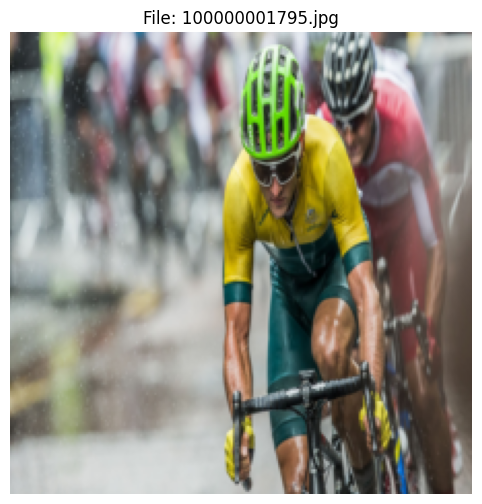


📌 Ground truth captions:
- hình_ảnh ấn_tượng của một tay_đua tập_trung hoàn_toàn vào đường_đua đầy thử_thách

🤖 Generated captions:
1: người vận_động_viên đang tăng_tốc trên đường_đua thể_hiện sự tập_trung cao_độ
2: người vận_động_viên đang tăng_tốc trên đường_đua thể_hiện sức_mạnh và tốc_độ
3: người vận_động_viên đang tăng_tốc trên đường_đua thể_hiện sức_mạnh và sự quyết_tâm
4: người vận_động_viên đang tăng_tốc trên đường_đua thể_hiện sự quyết_tâm trong cuộc đua
5: người vận_động_viên đang tăng_tốc trên đường_đua thể_hiện sự quyết_tâm trong cuộc đua xe_đạp


In [9]:
# Test on a random image
images, captions, img_names, raw_tokens = next(iter(test_loader))
image = images[0]
img_name = img_names[0]

# Display image
plt.figure(figsize=(8, 6))
plt.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title(f"File: {img_name}")
plt.axis('off')
plt.show()

# Print ground truth captions
print("\n📌 Ground truth captions:")
for cap in raw_tokens:
    print("-", ' '.join(cap))

# Print generated captions
print("\n🤖 Generated captions:")
captions = model.generate_caption(image.to(device), vocab, inv_vocab, max_length=20, beam_width=5)
for i, cap in enumerate(captions):
    print(f"{i+1}:", cap)